## Imports

In [24]:
!pip install pymoo


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# IMPORTS
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import random
from tensorflow.keras.models import clone_model
from keras.utils import to_categorical


## Classes

In [26]:
# CLASSES

class Server:
    def __init__(self, devices_list):
        self.model = Server.create_model()
        self.current_learning_iteration = 0
        self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = []
        self.x_test_global = []
        self.y_test_global = []
        self.devices = devices_list

    # def evaluate(self, verbose = 1):
    #     test_loss, test_acc = self.model.evaluate(self.x_test_global, self.y_test_global, verbose)
    #     return test_loss, test_acc

    def evaluate(self, x_test=None, y_test=None, verbose = 1):
        if x_test is None and y_test is None:
            test_loss, test_acc = self.model.evaluate(self.x_test_global, self.y_test_global, verbose)
            return test_loss, test_acc
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=verbose)
        return test_loss, test_acc

    def get_weights(self):
        return self.model.get_weights()

    def set_aggregated_weight(self):
        self.model.set_weight(Server.aggregate_weights())

    def give_global_model_weights_to_bitstring_devices(self, bitstring):
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                device.model.set_weights(self.model.get_weights())

    def create_model():
        model = keras.Sequential([
            layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                        # new
                        loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def aggregate_weights(self, bitstring):
        """Computes the weighted average of model weights from all devices and updates the global model."""
        def sum_all_nested_lists(list_of_lists):
            def recursive_sum(lists):
                if isinstance(lists[0], list):
                    return [recursive_sum([lst[i] for lst in lists]) for i in range(len(lists[0]))]
                else:
                    return sum(lists)

            return recursive_sum(list_of_lists)

        def multiply_nested_list(lst, factor):
            result = []
            for item in lst:
                if isinstance(item, list):
                    # Recursively handle sublists
                    result.append(multiply_nested_list(item, factor))
                else:
                    # Multiply number
                    result.append(item * factor)
            return result

        selected_devices = []
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                selected_devices.append(device)

        num_devices = len(selected_devices)
        if num_devices == 0:
            print("No devices available for aggregation.")
            return

        device_participation_ratio = []
        data_lengths = []

        for device in selected_devices:
            print("*******************")
            print(device.id)
            device_participation_ratio.append(device.last_round_participated / self.current_learning_iteration)
            # print("this device's participation ratio:")
            # print(device.last_round_participated / self.current_learning_iteration)
            data_lengths.append(len(device.data[0]))
            # print("this device's data to all ratio:")
            # print(len(device.data[0])/60000.0)

        sum_data = 0
        for data_len in data_lengths:
            sum_data += data_len

        data_fractions = []
        for device in selected_devices:
            data_fractions.append(len(device.data[0])/float(sum_data))



        # new
        combined_weights = [fraction * ratio for fraction, ratio in zip(data_fractions, device_participation_ratio)]
        total_weight = sum(combined_weights)
        normalized_weights = [w / total_weight for w in combined_weights]
        print(normalized_weights)


        aggregated_weights_devices = []
        for d in range(len(selected_devices)):
            # aggregated_weights_devices.append(multiply_nested_list(selected_devices[d].model.get_weights(), data_fractions[d]*device_participation_ratio[d]))
            aggregated_weights_devices.append(multiply_nested_list(self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], normalized_weights[d]))

        aggregated_weights = sum_all_nested_lists(aggregated_weights_devices)
        # TODO: Weighted multiplication for each node in each layer of the neural network of the received devices and then summing
        #       the related parts together so that we get a full weighted average of all these devices' models

        print("Aggregated weights:")
        for layer_idx, layer_weights in enumerate(aggregated_weights):
            print(f"Layer {layer_idx}: {layer_weights.shape}")
            
        
        return aggregated_weights


class Device:
    def __init__(self, id, ram, storage, cpu, bandwidth, battery, charging):
        self.id = id
        self.ram = ram
        self.storage = storage
        self.cpu = cpu
        self.bandwidth = bandwidth
        self.battery = battery
        self.charging = charging
        self.model = Server.create_model()
        self.last_round_participated = 0
        self.data = None  # Placeholder for dataset partition
        self.test_data = None
        self.number_of_times_fitted = 0
        
    def lose_battery(self):
        if float(self.battery) > 0.3:
            self.battery -= 0.3
        else:
            self.battery = 0
        


## Functions

In [27]:
# Functions

def fit_bitstring_devices(bitstring, server: Server, epochs=7):
    '''
    server: for using its "current_learning_iteration" variable
    '''

    server.current_learning_iteration += 1
    for device in server.devices:
        if bitstring[int(device.id)] == 1:
            # new
            device.lose_battery()
            
            device.model.fit(device.data[0], device.data[1], epochs=epochs, verbose=1)
            print(device.id)
            device.last_round_participated = server.current_learning_iteration
            server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(device.id)] = device.model.get_weights()
            device.number_of_times_fitted += 1



## Load Data

### Load Devices

In [28]:
# Load dataset from CSV
csv_file = 'devices.csv'
df = pd.read_csv(csv_file)
df.columns = df.columns.str.strip().str.lower()

# Convert CSV rows into device objects
devices = []

for _, row in df.iterrows():
    device = Device(
        row['id'], row['ram'], row['storage'], row['cpu'], row['bandwidth'], row['battery'],
        row.get('charging', 0)
    )
    devices.append(device)


# LIMIT TO 30 DEVICES
devices = devices[:30]

d:\Github Repos\FL\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Object Initializations

In [29]:
# Global Model
server = Server(devices_list=devices)
server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = [None for _ in range(len(devices))]

### Split Data Among Devices

In [30]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Convert labels to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Normalize data and reshape for CNN
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # Add channel dimension

x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)  # Add channel dimension

# Shuffle data
# indices = np.arange(len(x_train))
# np.random.shuffle(indices)
# x_train, y_train = x_train[indices], y_train[indices]




# new
# Lower the amount of data for devices
x_train = x_train[:int(len(x_train)/8)]
y_train = y_train[:int(len(y_train)/8)]




# Correct test split
split_index = int(0.8 * len(x_test))
x_test_devices, y_test_devices = x_test[:split_index], y_test[:split_index]
server.x_test_global, server.y_test_global = x_test[split_index:], y_test[split_index:]

# Training data (for devices)
x_train_devices, y_train_devices = x_train, y_train

# Split training data among devices
num_devices = len(devices)
split_size = len(x_train_devices) // num_devices

for i, device in enumerate(devices):
    start = i * split_size
    end = (i + 1) * split_size if i < num_devices - 1 else len(x_train_devices)
    device.data = (x_train_devices[start:end], y_train_devices[start:end])

# Split test data (device-level)
split_size = len(x_test_devices) // num_devices

for i, device in enumerate(devices):
    start = i * split_size
    end = (i + 1) * split_size if i < num_devices - 1 else len(x_test_devices)
    device.test_data = (x_test_devices[start:end], y_test_devices[start:end])

### Load Other Data

## First Iteration

In [31]:
# First Iteration
bitstring = [1 for _ in range(len(devices))]
print(bitstring)

# global model sends its weights to all devices
server.give_global_model_weights_to_bitstring_devices(bitstring)

test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.4f}")
print("------------------------------------------------------------")
fit_bitstring_devices(bitstring, server)
server.model.set_weights(server.aggregate_weights(bitstring))
print("------------------------------------------------------------")
test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.4f}")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1486 - loss: 2.3154 
Global Model Accuracy: 0.1530
------------------------------------------------------------
Epoch 1/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1298 - loss: 2.3117  
Epoch 2/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2424 - loss: 2.2584 
Epoch 3/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3278 - loss: 2.2020 
Epoch 4/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4156 - loss: 2.1690 
Epoch 5/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4665 - loss: 2.0849 
Epoch 6/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5430 - loss: 2.0399 
Epoch 7/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5927 - loss: 1.9987 
0.0
Epoch 1/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1664 - loss: 2.3079  
Epoch 2/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2786 - loss: 2.2521 


In [32]:
!pip install pymoo


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## NSGA2 Loop

In [33]:
# Parameters
NUM_ROUNDS = 1

In [34]:
import random

def generate_random_binary_list(size):
    return [random.randint(0, 1) for _ in range(size)]

In [35]:

all_runs_fronts = []  # Stores results across runs
all_runs_solutions = []

for i in range(NUM_ROUNDS):
    # Step 3: Run Optimization
    print("GLOBAL MODEL BEFORE OPTIMIZATION")
    print(server.evaluate())

    print("GLOBAL MODEL AFTER OPTIMIZATION")
    print(server.evaluate())

    bitstring = generate_random_binary_list(len(devices))
    print("Bitstring: ", bitstring)
    print(bitstring.count(1), "devices selected randomly")

    a = server.model.get_weights()
    test_loss, test_acc = server.evaluate()
    print(f"Global Model Accuracy: {test_acc:.4f}")
    print("------------------------------------------------------------")
    print(server.current_learning_iteration, " 1")
    server.give_global_model_weights_to_bitstring_devices(bitstring)
    print(server.current_learning_iteration, " 2")
    fit_bitstring_devices(bitstring, server=server, epochs=15)
    print(server.current_learning_iteration, " 3")
    server.model.set_weights(server.aggregate_weights(bitstring))
    print(server.current_learning_iteration, " 4")
    print("------------------------------------------------------------")
    test_loss, test_acc = server.evaluate()
    print(f"Global Model Accuracy: {test_acc:.4f}")


GLOBAL MODEL BEFORE OPTIMIZATION
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 815us/step - accuracy: 0.6500 - loss: 1.9512
(1.963024377822876, 0.6504999995231628)
GLOBAL MODEL AFTER OPTIMIZATION
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 802us/step - accuracy: 0.6500 - loss: 1.9512
(1.963024377822876, 0.6504999995231628)
Bitstring:  [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0]
15 devices selected randomly
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step - accuracy: 0.6500 - loss: 1.9512
Global Model Accuracy: 0.6505
------------------------------------------------------------
1  1
1  2
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6466 - loss: 1.9811 
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7038 - loss: 1.8877 
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7811 - loss: 1.7449 
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8023 - loss: 1.6072 
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc

011111001001001000111101110100

000010100100010101100010110000

110001111000010100100001010010

011011101111111100000011101000

1
[[array([[0.5065648 , 0.60150375, 0.32499999],
       [0.52519245, 0.58195488, 0.3215    ],
       [0.52226133, 0.58552631, 0.32749999],
       [0.52889371, 0.58469703, 0.3075    ]]), array([[0.52889371, 0.58469703, 0.3075    ],
       [0.52313136, 0.60194603, 0.30900002],
       [0.51630991, 0.5786056 , 0.31099999],
       [0.50229455, 0.59452201, 0.324     ],
       [0.53019189, 0.5708502 , 0.30849999],
       [0.52715871, 0.58670112, 0.30949998],
       [0.53750456, 0.58458646, 0.30800003]]), array([[0.52889371, 0.58469703, 0.3075    ],
       [0.51630991, 0.5786056 , 0.31099999],
       [0.53019189, 0.5708502 , 0.30849999],
       [0.53750456, 0.58458646, 0.30800003],
       [0.5149293 , 0.58646616, 0.30150002],
       [0.49403532, 0.58834586, 0.315     ],
       [0.5108874 , 0.58345864, 0.32200003],
       [0.52617846, 0.58333333, 0.31050003]]), array([

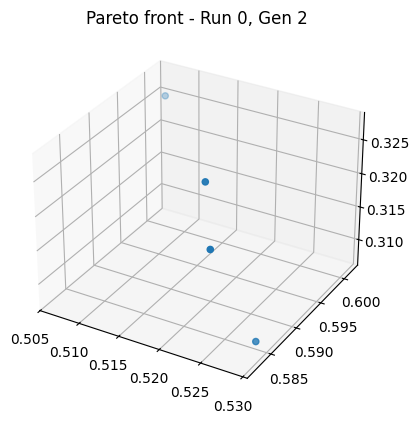

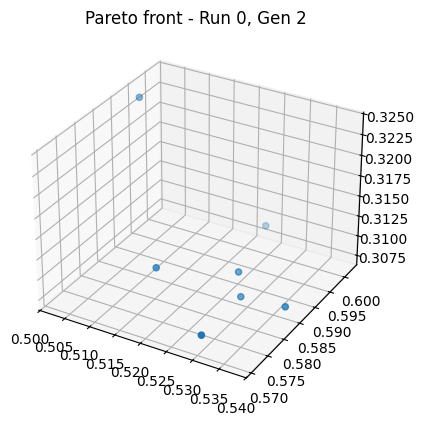

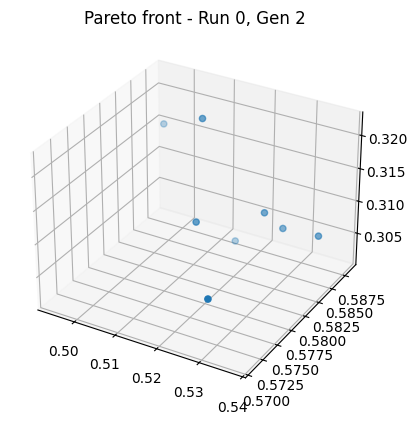

In [37]:
import matplotlib.pyplot as plt

for solution in all_runs_solutions[0][0]:
    print(str(solution).replace('True','1').replace('False','0').replace(' ','').replace('[','').replace(']','').replace('\n',''))
    print()
print(len(all_runs_solutions))
print(all_runs_fronts)

# Example: visualize the Pareto front from generation 2 of run 0 (if 3 objectives)
front = all_runs_fronts[0][0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(front[:,0], front[:,1], front[:,2])
ax.set_title("Pareto front - Run 0, Gen 2")
plt.show()

front = all_runs_fronts[0][1]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(front[:,0], front[:,1], front[:,2])
ax.set_title("Pareto front - Run 0, Gen 2")
plt.show()

front = all_runs_fronts[0][2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(front[:,0], front[:,1], front[:,2])
ax.set_title("Pareto front - Run 0, Gen 2")
plt.show()

In [35]:
import plotly.graph_objects as go

# Choose a generation and run
gen_idx = 0
run_idx = 0

for run_idx in range(len(all_runs_fronts)):
    for gen_idx in range(len(all_runs_fronts[run_idx])):
        
        front = all_runs_fronts[run_idx][gen_idx]

        fig = go.Figure(data=[go.Scatter3d(
            x=front[:, 0],
            y=front[:, 1],
            z=front[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color=front[:, 2],  # Color by third objective
                colorscale='Viridis',
                opacity=0.8
            )
        )])

        fig.update_layout(
            title=f"Pareto Front - Run {run_idx}, Gen {gen_idx}",
            scene=dict(
                xaxis=dict(title="Objective 1", range=[0, 1]),
                yaxis=dict(title="Objective 2", range=[0, 1]),
                zaxis=dict(title="Objective 3", range=[0, 1])
            )
        )

        fig.show()
